# Data Validation for Collaborative Cluster Configuration Optimization

In [1]:
# To display execution time of code
%load_ext autotime
# %unload_ext autotime
import sys
sys.path.insert(0, '..')
import collections
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pdfkit
import seaborn as sns

from operator import attrgetter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from IPython.display import display, HTML
from ipywidgets import IntProgress
from itertools import permutations

from RuntimePrediction.Predict import Predictor as C3OPredictor
from RuntimePrediction.DefaultModels import (GradientBoosting as GB,
                                             ErnestModel as EM)
from RuntimePrediction.CustomModels import (BasicOptimisticModel as BOM,
                                            OptimisticGradientBoosting as OGB)
pd.set_option('display.max_rows', 1600)

time: 2.2 s (started: 2022-04-16 10:17:35 +02:00)


## Define Models

In [2]:
Model = collections.namedtuple('Model', ['name', 'predictor', 'kwargs'])

models = [
          Model('Ernest', EM, {}),
          Model('GBM', GB, {}),
          Model('BOM', BOM, {}), 
          Model('OGB', OGB, {}),
          Model('C3O', C3OPredictor, {}),
         ]

time: 0 ns (started: 2022-04-16 10:17:38 +02:00)


## Extract Runtime Data

In [7]:
sort_df = pd.read_csv('../data/sort.tsv', sep='\t')
grep_df = pd.read_csv('../data/grep.tsv', sep='\t')
sgd_df = pd.read_csv('../data/sgd.tsv', sep='\t')
kmeans_df = pd.read_csv('../data/kmeans.tsv', sep='\t')
pagerank_df = pd.read_csv('../data/pagerank.tsv', sep='\t')
new_sort_df = pd.read_csv('../data/false_data_sort.tsv', sep='\t')
new_grep_df = pd.read_csv('../data/false_data_grep.tsv', sep='\t')
new_sgd_df = pd.read_csv('../data/false_data_sgd.tsv', sep='\t')
new_kmeans_df = pd.read_csv('../data/false_data_kmeans.tsv', sep='\t')
new_pagerank_df = pd.read_csv('../data/false_data_pagerank.tsv', sep='\t')
outliers_sort_df = pd.read_csv('../data/outliers_sort.tsv', sep='\t')
outliers_grep_df = pd.read_csv('../data/outliers_grep.tsv', sep='\t')
outliers_sgd_df = pd.read_csv('../data/outliers_sgd.tsv', sep='\t')
outliers_kmeans_df = pd.read_csv('../data/outliers_kmeans.tsv', sep='\t')
outliers_pagerank_df = pd.read_csv('../data/outliers_pagerank.tsv', sep='\t')
dir_cont = os.listdir('../contributions')
dir_pagerank_cont = os.listdir('../pagerank_contributions')

time: 31 ms (started: 2022-04-16 10:20:28 +02:00)


In [8]:
def filename_to_jobname(filename):
    if filename == 'sgd':
        return 'SGDLR'
    if filename == 'kmeans':
        return 'K-Means'
    if filename == 'pagerank':
        return 'Page Rank'
    else:
        return filename.capitalize()

time: 16 ms (started: 2022-04-16 10:20:31 +02:00)


In [9]:
def jobname_to_filename(job_name):
    if job_name == 'Sort':
        return 'sort'
    if job_name == 'Grep':
        return 'grep'
    if job_name == 'SGDLR':
        return 'sgd'
    if job_name == 'K-Means':
        return 'kmeans'
    if job_name == 'Page Rank':
        return 'pagerank'

time: 0 ns (started: 2022-04-16 10:20:32 +02:00)


In [10]:
def contributions_to_list(directory_list, path):
    contributions = []
    Contribution = collections.namedtuple('Contribution', ['jobname','userid','date','data'])
    if directory_list != []:
        for c in directory_list:
            if c == '.ipynb_checkpoints':
                continue
            name = c.split('_')[0]
            userid = c.split('_')[1]
            date = c.split('_')[2]
            date = date[:-4]
            filepath = path +c
            try: data = pd.read_csv(filepath, sep='\t')
            except: print('Empty Contribution!')
            contributions.append(Contribution(filename_to_jobname(name),userid,date,data))
        return contributions
    else: 
        print('No contributions found!')
        return contributions

time: 0 ns (started: 2022-04-16 10:20:33 +02:00)


In [11]:
sort_features = ['data_size_MB']
grep_features = ['data_size_MB', 'p_occurrence']
sgd_features = ['observations', 'features', 'iterations']
kmeans_features = ['observations', 'features', 'k']
pagerank_features = ['links', 'pages', 'convergence_criterion']

sort_filters = [('machine_type', '==', 'c4.2xlarge'), ('line_length', '==', 100)]
grep_filters = [('machine_type', '==', 'm4.2xlarge')]
sgd_filters = [('machine_type', '==', 'r4.2xlarge'), ('instance_count', '>', 2)]
kmeans_filters = [('machine_type', '==', 'r4.2xlarge'),('instance_count', '>', 2)]
pagerank_filters = [('machine_type', '==', 'r4.2xlarge')]

contributions = contributions_to_list(dir_cont,'../contributions/')
pagerank_contributions = contributions_to_list(dir_pagerank_cont, '../pagerank_contributions/')

time: 47 ms (started: 2022-04-16 10:20:34 +02:00)


## Data Extension

In [12]:
def add_outliers_to_df(df, job_name, extension_rate):
    n = len(df.sample(frac=extension_rate))
    filename = 'outliers_'+str(jobname_to_filename(job_name))+'_df'
    if n <= len((globals()[filename]).index):
        # Pick random points to add
        add_df = (globals()[filename]).sample(n)
        return df.append(add_df)
    else:
        print('New Dataframe for '+job_name+' is not big enough! You need at least ' + str(n) + ' new Datapoints.')

time: 0 ns (started: 2022-04-16 10:20:44 +02:00)


In [13]:
def add_falsedata_to_df(df, job_name, extension_rate):
    n = len(df.sample(frac=extension_rate))
    filename = 'new_'+str(jobname_to_filename(job_name))+'_df'
    if n <= len((globals()[filename]).index):
        # Pick random points to add
        add_df = (globals()[filename]).sample(n)
        return df.append(add_df)
    else:
        print('New Dataframe for '+job_name+' is not big enough! You need at least ' + str(n) + ' new Datapoints.')   

time: 0 ns (started: 2022-04-16 10:20:45 +02:00)


In [14]:
def add_extension_to_df(df, job_name, extension_rate, case):
    
    # case 1: adding outliers to df
    if case == 1:
        return add_outliers_to_df(df, job_name, extension_rate)
    
    # case 2: adding false data to df (not as bad as outliers)
    elif case == 2:
        extended_df = add_falsedata_to_df(df, job_name, extension_rate)
        if type(extended_df) != type(None):
            return extended_df
        else:
            return df
    else:
        return df

time: 0 ns (started: 2022-04-16 10:20:48 +02:00)


In [16]:
def merge_same_contributions_to_dataset(job_filename):
    # Adding all user contributions with the same job type to job df
    allconts = pd.DataFrame()
    job_features = globals()[job_filename+'_features']
    job_filters = globals()[job_filename+'_filters']
    job_df = globals()[job_filename+'_df']
    
    ## substitude pagerank_contributions with contributions if needed
    for cont in pagerank_contributions:
        if len(cont.data.index) >= 10:
            if cont.jobname == filename_to_jobname(job_filename):
                allconts = allconts.append(cont.data)
        else:
            print('User dataframe of '+str(cont.userid)+ ' for '+str(cont.jobname)+' at '+str(cont.date)+ ' is not big enough! You need at least 10 new Datapoints.')      
    
    # Drop column user_id
    allconts.drop('user_id', inplace=True, axis=1)
    
    # Merge datasets
    prep_data = job_df.append(allconts)
    prep_data.reset_index(drop=True, inplace=True)

    # Pre Processing of new dataset
    prep_data = get_training_data(prep_data,filename_to_jobname(job_filename),job_features,job_filters,0,2)
    
    return [prep_data[0],prep_data[1]]

time: 0 ns (started: 2022-04-16 10:20:54 +02:00)


In [17]:
def merge_contribution_to_dataset(cont_name, cont_data):
    for job in jobs:
        if job.name == cont_name:
            job_filename = jobname_to_filename(job.name)
            job_df = globals()[job_filename+'_df']
            job_features = globals()[job_filename+'_features']
            job_filters = globals()[job_filename+'_filters']
           
            ## Pre processing of new data ##

            # Drop column user_id
            cont_data.drop('user_id', inplace=True, axis=1)

            # Merge datasets
            prep_data = job_df.append(cont_data)
            prep_data.reset_index(drop=True, inplace=True)

            # Pre Processing of new dataset
            prep_data = get_training_data(prep_data,job.name,job_features,job_filters,0,2)

            return [prep_data[0],prep_data[1]]

time: 0 ns (started: 2022-04-16 10:20:55 +02:00)


## Data Pre-Processing

In [18]:
def filter_df(df, filters):
    # Apply filters
    for k, s, v in filters:
        if s == '==': df = df[df[k] == v] 
        if s == '>' : df = df[df[k] >  v]
    return df

time: 0 ns (started: 2022-04-16 10:20:58 +02:00)


In [19]:
def get_training_data(df, job_name, features, filters, extension_rate, case):
    ### Pre processing ###
    
    # Extend dataframe if needed
    if extension_rate > 0:
        df = add_extension_to_df(df, job_name, extension_rate, case)
        
    # Get groups of dataframe (of same data points)
    g = df.groupby(by=['instance_count','machine_type']+features)
    
    # Get data point from the middle of every group (less volatile to outliers than arithm. value)
    #df = pd.DataFrame(g.median().to_records())
    
    # Get mean values of groups (more volatile to outliers)
    df = pd.DataFrame(g.mean().to_records())
    
    # Filter dataframe
    df = filter_df(df, filters)

    # Place filtered Dataset into file (if needed)
    #place_df_into_csv(df,job_name)
    
    # Reset indices
    df.reset_index(drop=True, inplace=True)
    
    X = df[['instance_count'] + features]
    y = (df[['gross_runtime']]).squeeze()
    return X, y

time: 0 ns (started: 2022-04-16 10:21:00 +02:00)


In [14]:
def place_df_into_csv(df,jobname):
    print_df = df
    #print_df.drop('machine_type', inplace=True, axis=1)
    #print_df.drop('user_id', inplace=True, axis=1)
    print_df.to_csv(jobname_to_filename(jobname)+'_filtered.csv',index=False)

time: 0 ns (started: 2022-04-15 12:49:44 +02:00)


In [20]:
Job = collections.namedtuple('Job', ['name', 'X', 'y'])
extension_rate = 0.0
case = 1 # Case 1 for outlier data extension, Case 2 for false data extension.
jobs = [
    Job('Sort',
        *(get_training_data(sort_df, 'Sort', sort_features, sort_filters, extension_rate, case)) ),
    Job('Grep',
        *(get_training_data(grep_df, 'Grep', grep_features, grep_filters, extension_rate, case)) ),
    Job('SGDLR',
        *(get_training_data(sgd_df, 'SGDLR', sgd_features, sgd_filters, extension_rate, case)) ),
    Job('K-Means',
        *(get_training_data(kmeans_df, 'K-Means', kmeans_features, kmeans_filters, extension_rate, case)) ),
    Job('Page Rank',
        *(get_training_data(pagerank_df, 'Page Rank', pagerank_features, pagerank_filters, extension_rate, case)) )
]

for job in jobs:
    print(job)

Job(name='Sort', X=    instance_count  data_size_MB
0                2          9630
1                2         11556
2                2         13482
3                2         15408
4                2         17334
5                2         19260
6                4          9630
7                4         11556
8                4         13482
9                4         15408
10               4         17334
11               4         19260
12               6          9630
13               6         11556
14               6         13482
15               6         15408
16               6         17334
17               6         19260
18               8          9630
19               8         11556
20               8         13482
21               8         15408
22               8         17334
23               8         19260
24              10          9630
25              10         11556
26              10         13482
27              10         15408
28              10      

## Train-Test Split Creations

In [21]:
common_features = {'Grep': ['p_occurrence'],
                   'SGDLR': ['iterations'],
                   'K-Means': ['k'],
                   'Page Rank': ['pages', 'convergence_criterion']}

def get_groups(X, y, common_features):
    # Get groups of observations that share the same value for certain features
    Xy = X.merge(y, right_index=True, left_index=True)
    grouped = Xy.groupby(by=common_features, as_index=True)
    X_keys, y_keys = [k for k in Xy.keys() if k != 'gross_runtime'], ['gross_runtime']
    Xs = [group[X_keys] for name, group in grouped]
    ys = [group[y_keys].squeeze() for name, group in grouped]
    return Xs, ys

time: 0 ns (started: 2022-04-16 10:21:18 +02:00)


In [22]:
def create_new_training_data(X, y, splits, test_size=.1):
    for _ in range(splits):
        yield train_test_split(X, y,test_size=test_size) 

time: 0 ns (started: 2022-04-16 10:21:19 +02:00)


## Evaluate Models on the Training Datasets

In [23]:
# Display tables side by side and get rid of horizontal scroll bar under tables
HTML('''<style> \
     .output {flex-direction: row; flex-wrap: wrap} \
     div.output_subarea {padding-left: 0mm; padding-right:3mm} \
     </style>''')

time: 0 ns (started: 2022-04-16 10:21:20 +02:00)


In [34]:
def display_evaluation_counts(job_name):
    
    try: results = pd.read_csv('pagerank_contributions_evaluation/pagerank_contributions_evaluation_mean.csv', header=None)
    except: print("No evaluation results thus far"); return
    
    rres = [(user_id, date, job, model, round(float(mape),4)) for user_id, date, job, model, mape in results.values]
    df = pd.DataFrame(rres, columns = ('User Id', 'Date', 'Job', 'Model', 'MAPE'))
    groups = df.groupby(by=['User Id', 'Date', 'Job', 'Model'], as_index=False)
    amounts = [(*group_key, len(instances)) for group_key, instances in groups]
    df = pd.DataFrame(amounts, columns=('User Id', 'Date', 'Job', 'Model', 'Amount'))
    #print(df)
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job_name].set_index(['Model', 'User Id'])[['Amount']].unstack()
    
    columns = (list(map(lambda x: x[1], jobdf.columns)))  # Puts global and local in order
    displaydf = pd.DataFrame(jobdf.values, index=jobdf.index, columns=columns) 
    
    try: table_html = displaydf.style._repr_html_()
    except: table_html = "None"
    
    display(HTML(f"<h3>{job_name}</h3>" + table_html ))

time: 0 ns (started: 2022-04-16 10:24:02 +02:00)


### Calculating the Model Prediction Errors

In [36]:
def evaluate(model, X_train, X_test, y_train, y_test, error_metric):
    model_instance = model.predictor(**model.kwargs)
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    error = error_metric(y_test, y_pred)
    return error

time: 0 ns (started: 2022-04-16 10:24:17 +02:00)


In [37]:
def create_new_data_extension_evaluation(amount, extension_rate):
    progress_bar = IntProgress(min=0, max=len(jobs)*amount); display(progress_bar)
    with open('validation_performance_results.csv', 'at') as f:
        for job in jobs:
            for split in create_new_training_data(job.X, job.y, splits=amount):
                for model in models:
                    error = evaluate(model, *split, MAPE)
                    f.write(f"{job.name},{model.name},{extension_rate},{error}\n")
                progress_bar.value += 1

time: 0 ns (started: 2022-04-16 10:24:17 +02:00)


In [38]:
def create_single_contribution_evaluation(amount, contribution_list):
    progress_bar = IntProgress(min=0, max=len(contribution_list)*amount); display(progress_bar)
    with open('validation_performance_results.csv', 'at') as f:
        for cont in contribution_list:
            if len(cont.data.index) >= 10:
                # evaluate with 10 datapoints per contribution
                merged_data = merge_contribution_to_dataset(cont.jobname, cont.data.sample(10))
                X = merged_data[0]
                y = merged_data[1]
                for split in create_new_training_data(X, y, splits=amount):
                    for model in models:
                        error = evaluate(model, *split, MAPE)
                        f.write(f"{cont.userid},{cont.date},{cont.jobname},{model.name},{error}\n")
                    progress_bar.value += 1
            else:
                print('User dataframe of '+str(cont.userid)+ ' for '+str(cont.jobname)+' at '+str(cont.date)+ ' is not big enough! You need at least 10 new Datapoints.')

time: 0 ns (started: 2022-04-16 10:24:18 +02:00)


In [39]:
def create_same_contributions_evaluation(amount, job_filename):
    progress_bar = IntProgress(min=0, max=amount); display(progress_bar)
    with open('validation_performance_results.csv', 'at') as f:
        merged_data = merge_same_contributions_to_dataset(job_filename)
        X = merged_data[0]
        y = merged_data[1]
        for split in create_new_training_data(X, y, splits=amount):
            for model in models:
                error = evaluate(model, *split, MAPE)
                f.write(f"{filename_to_jobname(job_filename)},{model.name},{error}\n")
            progress_bar.value += 1

time: 0 ns (started: 2022-04-16 10:24:19 +02:00)


## Conduct Model Evaluation Experiments

In [284]:
create_new_data_extension_evaluation(amount=10, extension_rate=0.2)

IntProgress(value=0, max=10)

time: 1min 25s (started: 2022-04-16 02:43:39 +02:00)


In [ ]:
# First param: number of repititions, second param: list of contributions
create_single_contribution_evaluation(100, contributions)

In [ ]:
create_same_contributions_evaluation(100, 'pagerank')

# TRIM Approach

In [63]:
def get_highest_residuals(index_list,lowest_residuals_list):
    return (list(set(index_list) - set(lowest_residuals_list)))

time: 0 ns (started: 2022-04-16 10:52:47 +02:00)


In [42]:
def trim_filter(x,y,count,lam,model):
    # Number of rows of X
    length = x.shape[0]
    # Number of columns of X
    width = x.shape[1]
    # put y points into array
    y = np.array(y)
    # sortierte liste der indizes
    inds = sorted(np.random.permutation(length))
    initinds = inds[:]
    clf = None
    newinds = []
    it = 0
    toterr = 100000
    lasterr = 200000
    clf = model.predictor(**model.kwargs) # originally a function is called where lambda is used as parameter
    while(sorted(inds)!=sorted(newinds) and it<400 and lasterr-toterr>1e-5):
        newinds = inds[:]
        lasterr = toterr
        subx = x.loc[inds]
        suby = y[inds]
        clf.fit(subx,suby)
        preds = clf.predict(x)-y
        residvec = np.square(preds)

        residtopns = sorted([(residvec[i],i) for i in range(length)])[:count]
        resid = [val[1] for val in residtopns]
        topnresid = [val[0] for val in residtopns]

        # set inds to indices of n largest values in error
        inds = sorted(resid)
        # recompute error
        toterr = sum(topnresid)
        it+=1
        
    return clf,lam,inds

time: 0 ns (started: 2022-04-16 10:24:37 +02:00)


In [ ]:
# With the original dataset
#X,y = get_training_data(pagerank_df,'Page Rank', pagerank_features, pagerank_filters, 0, 1)

# With user contributions included
data = merge_same_contributions_to_dataset('pagerank')
X = data[0]
y = data[1]

inds = sorted(np.random.permutation(X.shape[0]))

### For evaluating all models ###
# for model in models:
#     trim_results = trim_filter(X,y,100,0.00001,model)
#     clf = trim_results[0]
#     lam = trim_results[1]
#     highest_residuals = trim_results[2]
#     print(clf, lam, np.sort(get_highest_residuals(inds,highest_residuals)))

### For evaluating one model with a specific number of residuals to be found ###
# trim_results = trim_filter(X,y,243,0.00001,models[1])
# clf = trim_results[0]
# lam = trim_results[1]
# highest_residuals = trim_results[2]
# print(clf, lam, np.sort(get_highest_residuals(inds,highest_residuals)))

### For evaluating all possible numbers of residuals to be found (from top to bottom)
for i in reversed(range(269)):
    trim_results = trim_filter(X,y,i,0.00001,models[4])
    clf = trim_results[0]
    lam = trim_results[1]
    highest_residuals = trim_results[2]
    print(clf, lam, np.sort(get_highest_residuals(inds,highest_residuals)))

# Visualisations

In [67]:
# Style the output to highlight the important information
def highlight_row_min(row):
    return ['color: black' if cell == min(row) else 'color: dimgray' for cell in row]

def highlight_min(data, color='aquamarine', bold=False):
    # highlight the minimum in a Series or DataFrame
    attr1 = f"background-color: {color}"
    attr2 = f"font-weight: {'bold' if bold else 'normal'}"
    if data.ndim == 1:
        is_min = data == data.min()
        return [attr1 if v else '' for v in is_min]
    else:
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr2, ''),
                            index=data.index, columns=data.columns)

time: 0 ns (started: 2022-04-16 10:56:50 +02:00)


In [64]:
def read_results(job_name):
    try: results = pd.read_csv('outliers_data_extension.csv', header=None)
    except: return
   
    rres = [(job, model, locality, float(mape)) for job, model, locality, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model','Locality','MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Locality'], as_index=False)
    df = groups.mean()

    # Filter info
    jobdf = df[df['Job'] == job_name].set_index(['Model', 'Locality'])
    return jobdf.unstack()['MAPE']

time: 0 ns (started: 2022-04-16 10:55:04 +02:00)


In [60]:
def display_job_evaluation(job_name):
    
    try: results = pd.read_csv('validation_performance_results.csv', header=None)
    except: print("No evaluation results thus far"); return
    
    rres = [(job, model, ds, round(float(mape),4)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Dataset', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Dataset'], as_index=False)
    df = groups.mean()
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job_name].set_index(['Model', 'Dataset'])[['MAPE']].unstack()
    # Remove redundant info
    columns = (list(map(lambda x: x[1], jobdf.columns)))  # Puts global and local in order
    displaydf = pd.DataFrame(jobdf.values, index=jobdf.index, columns=columns)    
    
    table_html = displaydf.style.apply(highlight_row_min,axis=1) \
                                .apply(highlight_min, axis=0, color='aquamarine') \
                                .apply(highlight_min, axis=None, bold=True) \
                                .format("{:.2%}") \
                                ._repr_html_()
    
    display(HTML(f"<h3>{job_name}</h3>" + table_html ))

time: 0 ns (started: 2022-04-16 10:45:51 +02:00)


In [66]:
def display_original_errors(job_name):
    
    try: results = pd.read_csv('original_errors.csv', header=None)
    except: print("No evaluation results thus far"); return
    
    rres = [(job, model, ds, round(float(mape),4)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Dataset', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Dataset'], as_index=False)
    df = groups.mean()
    
    # Filter info
    jobdf = df[(df['Job'] == job_name) & (df['Dataset'] == 'global')].set_index(['Model'])
    jobdf.drop('Dataset', inplace=True, axis=1)
    jobdf.drop('Job', inplace=True, axis=1)
    
    table_html = jobdf.style.apply(highlight_row_min,axis=1) \
                                .apply(highlight_min, axis=0, color='aquamarine') \
                                .apply(highlight_min, axis=None, bold=True) \
                                .format("{:.2%}") \
                                ._repr_html_()
    
    display(HTML(f"<h3>{job_name}</h3>" + table_html))
    
for job in jobs:
    display_original_errors(job.name)

,MAPE
Model,
BOM,6.39%
C3O,2.61%
Ernest,5.82%
GBM,4.43%
OGB,2.61%


,MAPE
Model,
BOM,12.95%
C3O,2.74%
Ernest,39.38%
GBM,2.74%
OGB,9.35%


,MAPE
Model,
BOM,12.66%
C3O,2.25%
Ernest,21.85%
GBM,2.25%
OGB,7.79%


,MAPE
Model,
BOM,5.74%
C3O,2.17%
Ernest,15.31%
GBM,2.17%
OGB,5.50%


,MAPE
Model,
BOM,15.08%
C3O,2.77%
Ernest,34.85%
GBM,2.71%
OGB,3.17%


time: 203 ms (started: 2022-04-16 10:56:26 +02:00)


In [47]:
def validate_user_results(MAPE_list):
    threshold_1 = 2.71
    threshold_2 = 5
    
    # select the minimum MAPE of all models
    minimum = np.min(MAPE_list)*100 
    
    if minimum < threshold_1:
        m = threshold_1 - minimum
        return str("This contribution will improve the system by "+str("{:.2}".format(m))+' %.')
    elif ((minimum > threshold_1) & (minimum < threshold_2)):
        m = minimum - threshold_1
        return str('This contribution will downgrade the prediction by '+str("{:.2}".format(m))+' %.')
    else:
        m = minimum - threshold_1
        x = "%.2f" % (m)
        return str('This contribution will sharply downgrade the prediction by '+str(x)+' %.')

time: 16 ms (started: 2022-04-16 10:37:56 +02:00)


In [52]:
def read_user_contribution_results(jobname, user_id, date):
    
    try: results = pd.read_csv('pagerank_contributions_evaluation/pagerank_contributions_evaluation.csv', header=None)
    except: print("No evaluation results thus far"); return
    
    rres = [(user_id, date, job, model, round(float(mape),4)) for user_id, date, job, model, mape in results.values]
    df = pd.DataFrame(rres, columns = ('User Id', 'Date', 'Job', 'Model', 'MAPE'))
    groups = df.groupby(by=['User Id', 'Date', 'Job', 'Model'], as_index=False)
    df = groups.mean()
    #print(df)
    # Filter info for just the job we are interested in
    filtered_df = df[(df['Job'] == jobname) & (df['User Id'] == int(user_id)) & (df['Date'] == int(date))].set_index(['Model'])
    #print(filtered_df)
    # Remove redundant info
    filtered_df.drop('Job', inplace=True, axis=1)
    filtered_df.drop('Date', inplace=True, axis=1)
    filtered_df.drop('User Id', inplace=True, axis=1)
    return filtered_df

time: 0 ns (started: 2022-04-16 10:41:30 +02:00)


In [49]:
def display_user_contribution_evaluation(jobname, user_id, date):
    
    try: displaydf = read_user_contribution_results(jobname, user_id, date)
    except: display(HTML(f"<h3>User ID: {user_id} </h3>"
                         f"<p>Algorithm: {jobname}</p>" 
                         f"<p>Date: {date}</p> None")); return
  
    values = displaydf['MAPE'].tolist()
  
    sentence = validate_user_results(values) # for output of user data comparison
    
    table_html = displaydf.style.apply(highlight_row_min,axis=1) \
                                .apply(highlight_min, axis=0, color='aquamarine') \
                                .apply(highlight_min, axis=None, bold=True) \
                                .format("{:.2%}") \
                                ._repr_html_()
    
    display(HTML(f"<h3>User ID: {user_id}</h3>" 
                 f"<h3>Jobtype: {jobname}</h3>" 
                 f"<h3>Date: {date}</h3>"+ table_html +f"<h5>Info: {sentence}</h3>"))

time: 0 ns (started: 2022-04-16 10:38:17 +02:00)


In [57]:
def display_same_contribution_evaluation(jobname):
    try: results = pd.read_csv('pagerank_contributions_evaluation/pagerank_same_all.csv', header=None)
    except: print("No evaluation results thus far"); return
    
    rres = [(job, model, round(float(mape),4)) for job, model, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model'], as_index=False)
    df = groups.mean()
   
    # Remove redundant info
    df.drop('Job', inplace=True, axis=1)
    new_df = df.set_index(['Model'])
    
    table_html = new_df.style.apply(highlight_row_min,axis=1) \
                                .apply(highlight_min, axis=0, color='aquamarine') \
                                .apply(highlight_min, axis=None, bold=True) \
                                .format("{:.2%}") \
                                ._repr_html_()
    
    display(HTML(f"<h3>Jobtype: {jobname}</h3>"+ table_html ))

time: 0 ns (started: 2022-04-16 10:44:54 +02:00)


In [34]:
def move_contribution_to_folder(jobname, ids):
    source = '../contributions'
    destination = '../FutureContributions'
    for file in dir_cont:
        for user_id in ids:
            if (file.split('_')[0] == jobname_to_filename(jobname)) and (file.split('_')[1] == str(user_id)):
                new_path = shutil.move(f"{source}/{file}", destination)

time: 0 ns (started: 2022-04-15 12:50:12 +02:00)


In [35]:
def compare_users_results(jobname, df):
    data = []
    user_ids = df.columns.tolist()
    min_values = []
    future_training_data = ''
    add_training_data = ''
    future_training_data_ids = []
    add_training_data_ids = []
    
    for i in user_ids:
        data.append((i, df[i].tolist()))
    
    for user_id, data in data:
        min_values.append((user_id, min(data)))
    
    for user_id, value in min_values:
        if ((value < 0.08) & (value > 0.03)):
            future_training_data_ids.append(user_id)
            future_training_data += 'user ' + str(user_id) +', ' 
        elif value <= 0.03:
            add_training_data_ids.append(user_id)
            add_training_data += 'user ' + str(user_id) +', '
            
    future_sentence = 'The contributions of '+ future_training_data+'will be added to the folder future contributions.'
    new_sentence = 'The contributions of '+ add_training_data+'will be added to the repository.'
    
    # Move possible future contributions to different folder
    if future_training_data_ids:
        move_contribution_to_folder(jobname, future_training_data_ids)
    
    if (future_training_data and add_training_data):
        return future_sentence +' '+ new_sentence
    elif future_training_data:
        return future_sentence
    elif add_training_data:
        return new_sentence

time: 0 ns (started: 2022-04-15 12:50:13 +02:00)


## Compare Contributions of the same Job Type

In [53]:
# compares user contributions with same jobname and stores them in Future_Contributions
def compare_user_contributions(jobname):
    try: results = pd.read_csv('pagerank_contributions_evaluation/pagerank_contributions_evaluation.csv', header=None)
    except: print("No evaluation results thus far"); return
    
    rres = [(user_id, date, job, model, round(float(mape),4)) for user_id, date, job, model, mape in results.values]
    df = pd.DataFrame(rres, columns = ('User Id', 'Date', 'Job', 'Model', 'MAPE'))
    groups = df.groupby(by=['User Id', 'Date', 'Job', 'Model'], as_index=False)
    df = groups.mean()
 
    # Filter info for just the job we are interested in
    job_df = df[df['Job'] == jobname].set_index(['Model','User Id'])
    
    # Remove redundant info
    job_df.drop('Job', inplace=True, axis=1)
    job_df.drop('Date', inplace=True, axis=1)
    
    # Group again for User IDs with multiple Dates
    user_group = job_df.groupby(by=['Model','User Id'], as_index=True)
    df = user_group.mean()

    # Make User Ids top row
    final_df = df.reset_index()
    final_df = df.unstack()['MAPE']
    
    # for output of user data comparison and to move the contribution to a different folder
    #sentence = compare_users_results(jobname, final_df) 
    
    table_html = final_df.style.apply(highlight_min, axis=0, color='aquamarine') \
                               .format("{:.2%}") \
                               ._repr_html_()
    
    
    display(HTML(f"<h3>Contributions: {jobname}</h3>" + table_html ))
#f"<h3>Analysis: {sentence}</h3>")

time: 0 ns (started: 2022-04-16 10:41:57 +02:00)


In [35]:
display_evaluation_counts('Page Rank')

,1,2,3,4,5,6,7,8,9,10
Model,,,,,,,,,,
BOM,100,100,100,100,100,100,100,100,100,100
C3O,100,100,100,100,100,100,100,100,100,100
Ernest,100,100,100,100,100,100,100,100,100,100
GBM,100,100,100,100,100,100,100,100,100,100
OGB,100,100,100,100,100,100,100,100,100,100


time: 31 ms (started: 2022-04-16 10:24:03 +02:00)


In [55]:
conts_jobnames = set([x.jobname for x in pagerank_contributions])
for i in conts_jobnames:
    compare_user_contributions(i) 

User Id,1,2,3,4,5,6,7,8,9,10
Model,,,,,,,,,,
BOM,18.66%,15.13%,14.85%,15.57%,16.88%,15.31%,16.40%,14.71%,14.61%,14.82%
C3O,14.08%,3.00%,2.40%,10.60%,14.72%,3.60%,4.79%,2.35%,2.35%,2.60%
Ernest,36.94%,34.85%,34.03%,34.42%,36.43%,33.63%,35.95%,34.31%,34.04%,34.38%
GBM,33.71%,3.23%,2.38%,24.27%,36.10%,3.90%,10.83%,2.35%,2.35%,2.56%
OGB,14.17%,2.97%,2.91%,10.63%,13.48%,3.60%,4.58%,2.93%,2.86%,3.02%


time: 47 ms (started: 2022-04-16 10:42:52 +02:00)


In [56]:
display_same_contribution_evaluation('Page Rank')

,MAPE
Model,
BOM,26.28%
C3O,27.14%
Ernest,41.86%
GBM,62.70%
OGB,27.14%


time: 16 ms (started: 2022-04-16 10:44:44 +02:00)


### List Contribution Evaluations 

In [58]:
for contribution in pagerank_contributions:
    display_user_contribution_evaluation(contribution.jobname, contribution.userid, contribution.date)

,MAPE
Model,
BOM,14.82%
C3O,2.60%
Ernest,34.38%
GBM,2.56%
OGB,3.02%


,MAPE
Model,
BOM,18.66%
C3O,14.08%
Ernest,36.94%
GBM,33.71%
OGB,14.17%


,MAPE
Model,
BOM,15.13%
C3O,3.00%
Ernest,34.85%
GBM,3.23%
OGB,2.97%


,MAPE
Model,
BOM,14.85%
C3O,2.40%
Ernest,34.03%
GBM,2.38%
OGB,2.91%


,MAPE
Model,
BOM,15.57%
C3O,10.60%
Ernest,34.42%
GBM,24.27%
OGB,10.63%


,MAPE
Model,
BOM,16.88%
C3O,14.72%
Ernest,36.43%
GBM,36.10%
OGB,13.48%


,MAPE
Model,
BOM,15.31%
C3O,3.60%
Ernest,33.63%
GBM,3.90%
OGB,3.60%


,MAPE
Model,
BOM,16.40%
C3O,4.79%
Ernest,35.95%
GBM,10.83%
OGB,4.58%


,MAPE
Model,
BOM,14.71%
C3O,2.35%
Ernest,34.31%
GBM,2.35%
OGB,2.93%


,MAPE
Model,
BOM,14.61%
C3O,2.35%
Ernest,34.04%
GBM,2.35%
OGB,2.86%


time: 266 ms (started: 2022-04-16 10:45:08 +02:00)


### Data Extension Plots

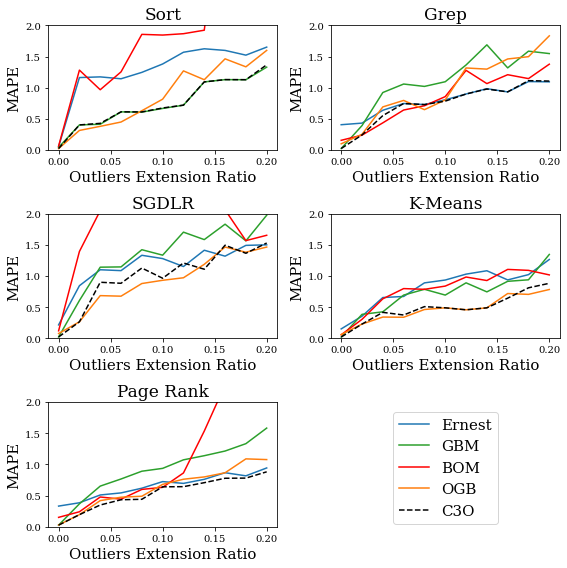

time: 532 ms (started: 2022-04-16 10:55:32 +02:00)


In [65]:
ff = 'DejaVu Serif'
matplotlib.rc('font', family=ff)

model_names = list(map(lambda m:m.name, models))

colors = ['tab:blue', 'tab:green', 'red', 'tab:orange', 'black']


plt.figure(figsize=(8,8))
for i, job in enumerate(jobs):
    results = read_results(job.name)
    plt.subplot(3,2,i+1)
    plt.title(job.name, fontsize=17)
    for j, model_name in enumerate(model_names):
        y = results.loc[model_name][:]
        x =  results.loc[model_name].keys()
        line = plt.plot(x, y, '--' if model_name=='C3O' else '-', label=model_name, color=colors[j])
        # set axis limits
        ax = plt.gca()
        ax.set_ylim([0, 2])
        plt.xlabel('Outliers Extension Ratio', fontsize=15)
        plt.ylabel('MAPE', fontsize=15)



plt.figlegend(model_names, fontsize=15, loc='lower center', ncol=1, bbox_to_anchor=[0.78, +.07], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
#plt.savefig('outliers_data_extension.pdf', bbox_inches='tight')
#plt.savefig('false_data_extension.pdf', bbox_inches='tight')
plt.show()